# **Acquiring the data**

We use the Python `requests` library to send a `GET` request to the FBI's public API endpoint for their Wanted Persons list. Our intention was to retrieve 500 records efficiently in a single call by setting the `pageSize` parameter to 500. The code includes error checking (raise_for_status) to ensure the request was successful and then parses the expected JSON response.

In [ ]:
import requests

api_url = "https://api.fbi.gov/wanted/v1/list"
params = {'pageSize': 500} # Set pageSize parameter to 500

try:
    response = requests.get(api_url, params=params)
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
    data = response.json()
    print(f"Number of items retrieved: {len(data.get('items', []))}")
    # print(data) # Uncomment to see the full data

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

Number of items retrieved: 50


In our previous attempt, simply asking the API for 500 records resulted in only 50 being returned, revealing a limitation in the API's maximum page size.

To overcome this, this cell employs a `pagination` strategy. Instead of one large request, it uses a `while` loop to make multiple, smaller requests to the FBI API. Each request specifically asks for 50 records (pageSize=50) from the next sequential page. The results from each successful request are accumulated until the target of 1060 records is met or the API runs out of data. This iterative approach allowed us to successfully gather all 1060 desired entries.

In [ ]:
import requests
import pandas as pd

api_url = "https://api.fbi.gov/wanted/v1/list"
all_items = []
pageSize = 50  # Keep the page size to 50 as before
current_page = 1

print("Attempting to fetch all entries using pagination...")

while True: # Loop indefinitely until explicitly broken
    params = {'pageSize': pageSize, 'page': current_page}
    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        data = response.json()
        items = data.get('items', [])

        if not items:
            print("No more items to retrieve.")
            break

        all_items.extend(items)
        print(f"Fetched {len(items)} items from page {current_page}. Total items collected: {len(all_items)}")

        current_page += 1

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        break

if all_items:
    df = pd.DataFrame(all_items) #in a pandas dataframe
    display(df.head())
    print(f"DataFrame created with {len(df)} entries.")
else:
    print("No data retrieved to create DataFrame.")

Attempting to fetch all entries using pagination...
Fetched 50 items from page 1. Total items collected: 50
Fetched 50 items from page 2. Total items collected: 100
Fetched 50 items from page 3. Total items collected: 150
Fetched 50 items from page 4. Total items collected: 200
Fetched 50 items from page 5. Total items collected: 250
Fetched 50 items from page 6. Total items collected: 300
Fetched 50 items from page 7. Total items collected: 350
Fetched 50 items from page 8. Total items collected: 400
Fetched 50 items from page 9. Total items collected: 450
Fetched 50 items from page 10. Total items collected: 500
Fetched 50 items from page 11. Total items collected: 550
Fetched 50 items from page 12. Total items collected: 600
Fetched 50 items from page 13. Total items collected: 650
Fetched 50 items from page 14. Total items collected: 700
Fetched 50 items from page 15. Total items collected: 750
Fetched 50 items from page 16. Total items collected: 800
Fetched 50 items from page 17.

,possible_states,warning_message,field_offices,details,locations,age_range,path,occupations,eyes_raw,scars_and_marks,...,status,build,weight_min,hair_raw,uid,sex,height_max,additional_information,age_max,pathId
0,None,None,[lasvegas],<p>The Federal Bureau of Investigation's Las V...,None,None,/wanted/seeking-info/defacement-of-federal-pro...,None,None,None,...,located,None,NaN,None,07f33176ac684ec19ac5a2794bdf196f,None,NaN,None,NaN,https://api.fbi.gov/@wanted-person/07f33176ac6...
1,None,None,[louisville],None,None,None,/wanted/cei/terry-matthews,None,Brown,Matthews has tattoos on his left and right for...,...,na,None,201.0,Brown,de4766a45bf4435bb3303b6da7d1febb,Male,73.0,None,NaN,https://api.fbi.gov/@wanted-person/de4766a45bf...
2,None,None,None,"<p>In June of 2021, Celeste Doghmi was reporte...",None,27 years old (at time of disappearance),/wanted/vicap/missing-persons/celeste-diana-do...,None,Brown,Doghmi has a large tattoo on her right leg of ...,...,na,None,110.0,"Brown, longer than shoulder length",5126982a11c6494fa53fb44d54c56206,Female,62.0,None,27.0,https://api.fbi.gov/@wanted-person/5126982a11c...
3,None,SHOULD BE CONSIDERED ARMED AND DANGEROUS,[miami],None,None,None,/wanted/additional/vitelhomme-innocent,None,Brown,None,...,na,None,150.0,Black,466379d55d804fdeabfc3944c5d44331,Male,70.0,None,NaN,https://api.fbi.gov/@wanted-person/466379d55d8...
4,None,SHOULD BE CONSIDERED A FLIGHT RISK,[dallas],None,None,None,/wanted/topten/cindy-rodriguez-singh,None,Brown,"Rodriguez Singh has tattoos on her back, left ...",...,na,None,120.0,Brown,fa908b7efed64603b9f95efa0288643f,Female,63.0,None,NaN,https://api.fbi.gov/@wanted-person/fa908b7efed...


DataFrame created with 1060 entries.


**Exploratory Data Analysis**

This summary confirms we have 500 entries with 54 features each. While essential fields like description and title are complete, the key insight here is the significant amount of missing data across many columns. Particularly important for our analysis, age information (age_min, age_max) is missing for a large majority of entries (only 119 out of 500 have it). This highlights an immediate challenge: the need for careful data cleaning and acknowledging the limitations imposed by this missing age data when testing our hypothesis.

In [ ]:
print('shape:', df.shape)
print('\ninfo:')
print(df.info())

shape: (1060, 54)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   possible_states         118 non-null    object 
 1   warning_message         271 non-null    object 
 2   field_offices           779 non-null    object 
 3   details                 601 non-null    object 
 4   locations               4 non-null      object 
 5   age_range               210 non-null    object 
 6   path                    1060 non-null   object 
 7   occupations             190 non-null    object 
 8   eyes_raw                751 non-null    object 
 9   scars_and_marks         279 non-null    object 
 10  weight                  646 non-null    object 
 11  poster_classification   1060 non-null   object 
 12  possible_countries      81 non-null     object 
 13  eyes                    741 non-null    object 
 14  files          

**Data Cleaning**

While simply counting missing values using df.isnull().sum() (which you might consider the usual way) tells us how many values are missing, calculating the percentage gives us a much clearer picture of the relative impact of that missing data. For instance, 100 missing values might be insignificant in a column with 10,000 entries but critical in a column with only 200 entries. By dividing the null count by the total number of rows (len(df)) and multiplying by 100, we get a standardized measure (0% to 100%) for each column. This makes it easier to compare the severity of missing data across different columns and helps in making informed decisions for data cleaning, such as setting a threshold (like 80% in the next step) to drop columns that are too sparse to be useful.

In [ ]:
#Shows how much data is missing in each column
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

possible_states           88.867925
warning_message           74.433962
field_offices             26.509434
details                   43.301887
locations                 99.622642
age_range                 80.188679
path                       0.000000
occupations               82.075472
eyes_raw                  29.150943
scars_and_marks           73.679245
weight                    39.056604
poster_classification      0.000000
possible_countries        92.358491
eyes                      30.094340
files                      0.000000
modified                   0.000000
age_min                   80.566038
caution                   56.509434
description                0.000000
person_classification      0.000000
hair                      26.415094
reward_max                 0.000000
title                      0.000000
coordinates                0.000000
place_of_birth            55.000000
languages                 86.037736
race_raw                  28.773585
reward_min                 0

In [ ]:
# Dropping columns with more than 80% missing values
missing_percentage = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percentage[missing_percentage > 80].index
df = df.drop(columns=columns_to_drop)

# Display the DataFrame info after dropping columns
print("DataFrame info after dropping columns with > 80% missing values:")
display(df.info())

DataFrame info after dropping columns with > 80% missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   warning_message        271 non-null    object 
 1   field_offices          779 non-null    object 
 2   details                601 non-null    object 
 3   path                   1060 non-null   object 
 4   eyes_raw               751 non-null    object 
 5   scars_and_marks        279 non-null    object 
 6   weight                 646 non-null    object 
 7   poster_classification  1060 non-null   object 
 8   eyes                   741 non-null    object 
 9   files                  1060 non-null   object 
 10  modified               1060 non-null   object 
 11  caution                461 non-null    object 
 12  description            1060 non-null   object 
 13  person_classification  1060 non-null   obje

None

**Hypothesis Analysis**

Let's create `df_selected` to focus only on the columns that are relevant to testing our hypothesis about whether cyber crimes are more frequent among young adults. This makes the data easier to work with for the analysis steps that follow.

In [ ]:
# Select the columns for hypothesis analysis
# Ensure we are using the DataFrame with 500 entries (created by fetching with pagination)
df_selected = df[['description', 'title', 'hair', 'eyes', 'field_offices', 'modified', 'publication', 'subjects', 'sex']]

# Display the first few rows of the new DataFrame
display(df_selected.head())

# Display information about the new DataFrame
display(df_selected.info())

,description,title,hair,eyes,field_offices,modified,publication,subjects,sex
0,"Las Vegas, Nevada\r\nJune 11, 2025",DEFACEMENT OF FEDERAL PROPERTY,None,None,[lasvegas],2025-07-08T19:27:28+00:00,2025-06-25T09:42:00,[Seeking Information],None
1,Conspiracy to Possess with Intent to Distribut...,TERRY MATTHEWS,brown,brown,[louisville],2025-07-02T14:33:15+00:00,2025-07-02T08:03:00,[Criminal Enterprise Investigations],Male
2,"Auburn, Maine\r\nJune 1, 2021","CELESTE DIANA DOGHMI - AUBURN, MAINE",brown,brown,None,2025-07-02T12:35:52+00:00,2025-07-02T07:26:00,[ViCAP Missing Persons],Female
3,Conspiracy to Commit Hostage Taking; Hostage T...,VITEL'HOMME INNOCENT,black,brown,[miami],2025-07-01T15:31:48+00:00,2022-11-03T10:49:00,[Additional Violent Crimes],Male
4,Unlawful Flight to Avoid Prosecution - Capital...,CINDY RODRIGUEZ SINGH,brown,brown,[dallas],2025-07-01T15:00:16+00:00,2024-07-11T13:11:00,"[Ten Most Wanted Fugitives, Case of the Week]",Female


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    1060 non-null   object
 1   title          1060 non-null   object
 2   hair           780 non-null    object
 3   eyes           741 non-null    object
 4   field_offices  779 non-null    object
 5   modified       1060 non-null   object
 6   publication    1060 non-null   object
 7   subjects       1060 non-null   object
 8   sex            870 non-null    object
dtypes: object(9)
memory usage: 74.7+ KB


None

**Categorical Analysis**

Lets do the analysis of different types of information in columns like hair color, eye color, where the FBI offices are, the gender of the individuals, and the main topics of their cases. It counts how many times each category appears, so we can see the most common characteristics in the dataset. This helps us understand the general breakdown of the data.

In [ ]:
print("Analysis of Categorical Columns:")

print("\nHair color distribution:")
display(df_selected['hair'].value_counts())

print("\nEye color distribution:")
display(df_selected['eyes'].value_counts())

print("\nField office distribution (showing top 10):")
display(df_selected['field_offices'].value_counts().head(10))

print("\nSex distribution:")
display(df_selected['sex'].value_counts())

print("\nSubject distribution (showing top 10):")
# Subjects is a list of strings, so we need to process it to get counts of individual subjects
from collections import Counter
all_subjects = [subject for sublist in df_selected['subjects'].dropna() for subject in sublist]
subject_counts = Counter(all_subjects)
display(pd.Series(subject_counts).sort_values(ascending=False).head(10))

Analysis of Categorical Columns:

Hair color distribution:


,count
hair,
brown,382
black,321
blond,49
gray,22
bald,6



Eye color distribution:


,count
eyes,
brown,546
blue,109
hazel,33
green,33
black,10
dark,10



Field office distribution (showing top 10):


,count
field_offices,
[washingtondc],82
[newyork],81
[losangeles],66
[miami],40
[newark],34
[chicago],26
[portland],22
[albuquerque],21
[sacramento],20



Sex distribution:


,count
sex,
Male,588
Female,264
,18



Subject distribution (showing top 10):


,0
Seeking Information,188
Cyber's Most Wanted,154
ViCAP Missing Persons,140
Kidnappings and Missing Persons,119
Counterintelligence,67
Violent Crime - Murders,57
ViCAP Unidentified Persons,55
Criminal Enterprise Investigations,50
Indian Country,48
Additional Violent Crimes,39


Lets count how often each word appears in the 'description', 'title', and 'publication' columns. It helps us see which words are most common in these text fields. We're looking at the top 20 most frequent words in each column.

In [ ]:
from collections import Counter
import re

def get_word_frequencies(text_series):
    """Calculates word frequencies from a pandas Series of text."""
    all_words = []
    # Use regex to find words (alphanumeric sequences)
    for text in text_series.dropna():
        words = re.findall(r'\w+', str(text).lower())
        all_words.extend(words)
    return Counter(all_words)

print("Analysis of Text Columns:")

print("\nDescription word frequencies (showing top 20):")
description_word_freq = get_word_frequencies(df_selected['description'])
display(pd.Series(description_word_freq).sort_values(ascending=False).head(20))

print("\nTitle word frequencies (showing top 20):")
title_word_freq = get_word_frequencies(df_selected['title'])
display(pd.Series(title_word_freq).sort_values(ascending=False).head(20))

print("\nPublication word frequencies (showing top 20):")
publication_word_freq = get_word_frequencies(df_selected['publication'])
display(pd.Series(publication_word_freq).sort_values(ascending=False).head(20))

Analysis of Text Columns:

Description word frequencies (showing top 20):


,0
to,889
conspiracy,617
of,359
fraud,329
commit,327
and,293
a,245
the,197
murder,189
wire,174



Title word frequencies (showing top 20):


,0
doe,64
john,46
jane,35
unknown,27
florida,23
jr,21
and,21
michigan,20
california,19
new,18



Publication word frequencies (showing top 20):


,0
00,1222
10,161
2024,158
2010,144
08,139
09,131
02,128
03,106
2022,102
06,101


**N-gram analysis**

Now let's look for common phrases, not just single words, in the 'description' column. It finds the most frequent two-word phrases (bigrams) and three-word phrases (trigrams) to see what kinds of combinations of words appear most often.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_ngrams(corpus, n=None, ngram_range=(1, 1)):
    """
    Calculates the frequency of n-grams in a corpus and returns the top n.
    """
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus.dropna())
    bag_of_words = vec.transform(corpus.dropna())
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Analysis of n-grams in 'description' column:")

# Get and display top 20 bigrams (two-word phrases)
print("\nTop 20 Bigrams in Descriptions:")
top_bigrams_desc = get_top_n_ngrams(df_selected['description'], n=20, ngram_range=(2, 2))
display(pd.DataFrame(top_bigrams_desc, columns=['Bigram', 'Frequency']))

# Get and display top 20 trigrams (three-word phrases)
print("\nTop 20 Trigrams in Descriptions:")
top_trigrams_desc = get_top_n_ngrams(df_selected['description'], n=20, ngram_range=(3, 3))
display(pd.DataFrame(top_trigrams_desc, columns=['Trigram', 'Frequency']))

Analysis of n-grams in 'description' column:

Top 20 Bigrams in Descriptions:


,Bigram,Frequency
0,conspiracy commit,281
1,wire fraud,172
2,identity theft,115
3,united states,104
4,unlawful flight,95
5,flight avoid,95
6,avoid prosecution,92
7,aggravated identity,90
8,money laundering,87
9,commit wire,86



Top 20 Trigrams in Descriptions:


,Trigram,Frequency
0,unlawful flight avoid,95
1,flight avoid prosecution,92
2,aggravated identity theft,90
3,commit wire fraud,85
4,conspiracy commit wire,77
5,conspiracy commit computer,56
6,international emergency economic,44
7,emergency economic powers,44
8,economic powers act,44
9,money laundering conspiracy,43


# Task
Analyze the provided dataset to determine if individuals wanted for certain types of crimes (e.g., violent crimes vs. white-collar crimes) are more likely to have tattoos than individuals wanted for other types of crimes. Use the 'description', 'title', 'subjects', and 'scars_and_marks' columns for the analysis.

## Refine crime type identification

### Subtask:
Use the insights from the n-gram analysis and relevant columns ('description', 'title', 'subjects') to categorize entries into specific crime types (e.g., violent crimes, white-collar crimes).


**Reasoning**:
Define keywords for violent and white-collar crimes based on previous analysis, create new boolean columns in the dataframe to categorize entries by these crime types, and then display the head of the updated dataframe and the counts for each crime type.



In [ ]:
# Define keywords for different crime types based on analysis of description, title, and subjects
violent_crime_keywords = [
    'murder', 'homicide', 'assault', 'battery', 'robbery', 'kidnapping',
    'violent crime', 'fugitive', 'ten most wanted', 'criminal enterprise investigations',
    'additional violent crimes', 'violent crime - murders' # Added from subjects analysis
]

white_collar_crime_keywords = [
    'fraud', 'wire fraud', 'mail fraud', 'computer fraud', 'identity theft',
    'money laundering', 'conspiracy commit wire', 'commit wire fraud',
    'aggravated identity theft', 'white-collar crime', 'cyber\'s most wanted' # Added from subjects and n-gram analysis
]

# Create new boolean columns for each crime type
df_selected['is_violent_crime'] = False
df_selected['is_white_collar_crime'] = False

# Function to check for keywords in text columns and subjects list
def contains_keywords(row, keywords):
    text_to_check = str(row['description']).lower() + " " + str(row['title']).lower()
    if isinstance(row['subjects'], list):
        text_to_check += " " + " ".join([str(s).lower() for s in row['subjects']])
    return any(keyword in text_to_check for keyword in keywords)

# Populate the new crime type columns
df_selected['is_violent_crime'] = df_selected.apply(lambda row: contains_keywords(row, violent_crime_keywords), axis=1)
df_selected['is_white_collar_crime'] = df_selected.apply(lambda row: contains_keywords(row, white_collar_crime_keywords), axis=1)

# Display the head of the DataFrame with the new columns
print("DataFrame head with new crime type columns:")
display(df_selected.head())

# Print the counts of entries for each identified crime type
print("\nCounts of entries by crime type:")
print(f"Violent Crimes: {df_selected['is_violent_crime'].sum()}")
print(f"White-Collar Crimes: {df_selected['is_white_collar_crime'].sum()}")

DataFrame head with new crime type columns:


/tmp/ipython-input-1856687324.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['is_violent_crime'] = False
/tmp/ipython-input-1856687324.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['is_white_collar_crime'] = False
/tmp/ipython-input-1856687324.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,description,title,hair,eyes,field_offices,modified,publication,subjects,sex,is_violent_crime,is_white_collar_crime
0,"Las Vegas, Nevada\r\nJune 11, 2025",DEFACEMENT OF FEDERAL PROPERTY,None,None,[lasvegas],2025-07-08T19:27:28+00:00,2025-06-25T09:42:00,[Seeking Information],None,False,False
1,Conspiracy to Possess with Intent to Distribut...,TERRY MATTHEWS,brown,brown,[louisville],2025-07-02T14:33:15+00:00,2025-07-02T08:03:00,[Criminal Enterprise Investigations],Male,True,False
2,"Auburn, Maine\r\nJune 1, 2021","CELESTE DIANA DOGHMI - AUBURN, MAINE",brown,brown,None,2025-07-02T12:35:52+00:00,2025-07-02T07:26:00,[ViCAP Missing Persons],Female,False,False
3,Conspiracy to Commit Hostage Taking; Hostage T...,VITEL'HOMME INNOCENT,black,brown,[miami],2025-07-01T15:31:48+00:00,2022-11-03T10:49:00,[Additional Violent Crimes],Male,True,False
4,Unlawful Flight to Avoid Prosecution - Capital...,CINDY RODRIGUEZ SINGH,brown,brown,[dallas],2025-07-01T15:00:16+00:00,2024-07-11T13:11:00,"[Ten Most Wanted Fugitives, Case of the Week]",Female,True,False



Counts of entries by crime type:
Violent Crimes: 488
White-Collar Crimes: 239


## Identify entries with tattoos

### Subtask:
Analyze the 'scars_and_marks' column to identify entries where tattoos are mentioned.


**Reasoning**:
Analyze the 'scars_and_marks' column to identify entries where tattoos are mentioned and create a boolean column for this.



**Reasoning**:
The previous attempt failed because the 'scars_and_marks' column was dropped from `df_selected` in a prior step. I need to re-create `df_selected` to include 'scars_and_marks' and then proceed with identifying tattoos.



In [ ]:
# Re-select the columns for hypothesis analysis, including 'scars_and_marks'
df_selected = df[['description', 'title', 'hair', 'eyes', 'field_offices', 'modified', 'publication', 'subjects', 'sex', 'scars_and_marks']]

# Analyze the 'scars_and_marks' column to identify entries with tattoos
# Create a new boolean column 'has_tattoo'
# Use .loc to avoid SettingWithCopyWarning
df_selected.loc[:, 'has_tattoo'] = df_selected['scars_and_marks'].apply(
    lambda x: 'tattoo' in str(x).lower() if pd.notnull(x) else False
)

# Print the number of entries identified as having tattoos
tattoo_count = df_selected['has_tattoo'].sum()
print(f"Number of entries identified as having tattoos: {tattoo_count}")

# Display the head of the df_selected DataFrame with the new has_tattoo column
display(df_selected.head())

Number of entries identified as having tattoos: 120


/tmp/ipython-input-2887364536.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'has_tattoo'] = df_selected['scars_and_marks'].apply(


,description,title,hair,eyes,field_offices,modified,publication,subjects,sex,scars_and_marks,has_tattoo
0,"Las Vegas, Nevada\r\nJune 11, 2025",DEFACEMENT OF FEDERAL PROPERTY,None,None,[lasvegas],2025-07-08T19:27:28+00:00,2025-06-25T09:42:00,[Seeking Information],None,None,False
1,Conspiracy to Possess with Intent to Distribut...,TERRY MATTHEWS,brown,brown,[louisville],2025-07-02T14:33:15+00:00,2025-07-02T08:03:00,[Criminal Enterprise Investigations],Male,Matthews has tattoos on his left and right for...,True
2,"Auburn, Maine\r\nJune 1, 2021","CELESTE DIANA DOGHMI - AUBURN, MAINE",brown,brown,None,2025-07-02T12:35:52+00:00,2025-07-02T07:26:00,[ViCAP Missing Persons],Female,Doghmi has a large tattoo on her right leg of ...,True
3,Conspiracy to Commit Hostage Taking; Hostage T...,VITEL'HOMME INNOCENT,black,brown,[miami],2025-07-01T15:31:48+00:00,2022-11-03T10:49:00,[Additional Violent Crimes],Male,None,False
4,Unlawful Flight to Avoid Prosecution - Capital...,CINDY RODRIGUEZ SINGH,brown,brown,[dallas],2025-07-01T15:00:16+00:00,2024-07-11T13:11:00,"[Ten Most Wanted Fugitives, Case of the Week]",Female,"Rodriguez Singh has tattoos on her back, left ...",True


## Compare proportions

### Subtask:
Calculate the proportion of individuals with tattoos within each crime type and compare these proportions.


**Reasoning**:
Calculate the total number of entries and cyber crime entries for both young adults and older adults, then compute and print the proportions.



**Reasoning**:
The previous code failed because the columns 'is_violent_crime' and 'is_white_collar_crime' were not present in the `df_selected` DataFrame. Re-create these columns based on the keyword lists defined in the previous successful subtask and then calculate the proportions of individuals with tattoos within each crime type as requested in the instructions.



In [ ]:
# Define keywords for different crime types based on analysis of description, title, and subjects
violent_crime_keywords = [
    'murder', 'homicide', 'assault', 'battery', 'robbery', 'kidnapping',
    'violent crime', 'fugitive', 'ten most wanted', 'criminal enterprise investigations',
    'additional violent crimes', 'violent crime - murders'
]

white_collar_crime_keywords = [
    'fraud', 'wire fraud', 'mail fraud', 'computer fraud', 'identity theft',
    'money laundering', 'conspiracy commit wire', 'commit wire fraud',
    'aggravated identity theft', 'white-collar crime', 'cyber\'s most wanted'
]

# Function to check for keywords in text columns and subjects list
def contains_keywords(row, keywords):
    text_to_check = str(row['description']).lower() + " " + str(row['title']).lower()
    if isinstance(row['subjects'], list):
        text_to_check += " " + " ".join([str(s).lower() for s in row['subjects']])
    return any(keyword in text_to_check for keyword in keywords)

# Create new boolean columns for each crime type
df_selected.loc[:, 'is_violent_crime'] = df_selected.apply(lambda row: contains_keywords(row, violent_crime_keywords), axis=1)
df_selected.loc[:, 'is_white_collar_crime'] = df_selected.apply(lambda row: contains_keywords(row, white_collar_crime_keywords), axis=1)

# 1. Calculate the total number of entries for violent crimes and white-collar crimes
total_violent_crimes = df_selected['is_violent_crime'].sum()
total_white_collar_crimes = df_selected['is_white_collar_crime'].sum()

# 2. Calculate the number of entries with tattoos within the violent crime group
violent_crime_with_tattoos = df_selected[(df_selected['is_violent_crime'] == True) & (df_selected['has_tattoo'] == True)].shape[0]

# 3. Calculate the number of entries with tattoos within the white-collar crime group
white_collar_crime_with_tattoos = df_selected[(df_selected['is_white_collar_crime'] == True) & (df_selected['has_tattoo'] == True)].shape[0]

# 4. Calculate the proportion of tattooed individuals in the violent crime group
proportion_violent_crime_tattoo = violent_crime_with_tattoos / total_violent_crimes if total_violent_crimes > 0 else 0

# 5. Calculate the proportion of tattooed individuals in the white-collar crime group
proportion_white_collar_crime_tattoo = white_collar_crime_with_tattoos / total_white_collar_crimes if total_white_collar_crimes > 0 else 0

# 6. Print the calculated proportions
print(f"Proportion of individuals with tattoos in Violent Crimes: {proportion_violent_crime_tattoo:.4f}")
print(f"Proportion of individuals with tattoos in White-Collar Crimes: {proportion_white_collar_crime_tattoo:.4f}")

Proportion of individuals with tattoos in Violent Crimes: 0.1393
Proportion of individuals with tattoos in White-Collar Crimes: 0.0335


/tmp/ipython-input-2319114689.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'is_violent_crime'] = df_selected.apply(lambda row: contains_keywords(row, violent_crime_keywords), axis=1)
/tmp/ipython-input-2319114689.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'is_white_collar_crime'] = df_selected.apply(lambda row: contains_keywords(row, white_collar_crime_keywords), axis=1)


## Statistical testing (optional but recommended)

### Subtask:
Consider using a statistical test (like a chi-squared test for proportions) to determine if the observed difference in proportions is statistically significant.


**Reasoning**:
Perform a chi-squared test to determine the statistical significance of the difference in proportions of tattoos between violent and white-collar crime groups.



In [ ]:
from scipy.stats import chi2_contingency
import numpy as np
contingency_table = np.array([
    [total_violent_crimes - violent_crime_with_tattoos, violent_crime_with_tattoos],
    [total_white_collar_crimes - white_collar_crime_with_tattoos, white_collar_crime_with_tattoos]
])

print("Contingency Table:")
display(contingency_table)

# Perform the chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table)

# Print the results
print(f"\nChi-squared Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print("Expected Frequencies:")
display(expected_frequencies)

# Interpret the p-value
alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than the significance level ({alpha}), so we reject the null hypothesis.")
    print("There is a statistically significant difference in the proportion of individuals with tattoos between violent and white-collar crime entries.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than the significance level ({alpha}), so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the proportion of individuals with tattoos between violent and white-collar crime entries.")

Contingency Table:


array([[420,  68],
       [231,   8]])


Chi-squared Statistic: 18.0951
P-value: 0.0000
Degrees of Freedom: 1
Expected Frequencies:


array([[436.98486933,  51.01513067],
       [214.01513067,  24.98486933]])


Interpretation:
The p-value (0.0000) is less than the significance level (0.05), so we reject the null hypothesis.
There is a statistically significant difference in the proportion of individuals with tattoos between violent and white-collar crime entries.


## Summarize findings

### Subtask:
Present the proportions and any statistical test results to address the hypothesis.


**Reasoning**:
State the hypothesis, report the proportions and summarize the statistical test results to address the hypothesis.



Hypothesis: Individuals wanted for violent crimes are more likely to have tattoos than individuals wanted for white-collar crimes.

Proportion of individuals with tattoos in Violent Crimes: 0.1393
Proportion of individuals with tattoos in White-Collar Crimes: 0.0335

Statistical Test Summary (Chi-squared test):
Test performed: Chi-squared test of independence
Calculated p-value: 0.0000
Significance level (alpha): 0.05
Result: We reject the null hypothesis.
Interpretation: There is a statistically significant difference in the proportion of individuals with tattoos between violent and white-collar crime entries.

Conclusion:
Based on the analysis, there is statistically significant evidence to support the hypothesis that individuals wanted for violent crimes are more likely to have tattoos than individuals wanted for white-collar crimes in this dataset.


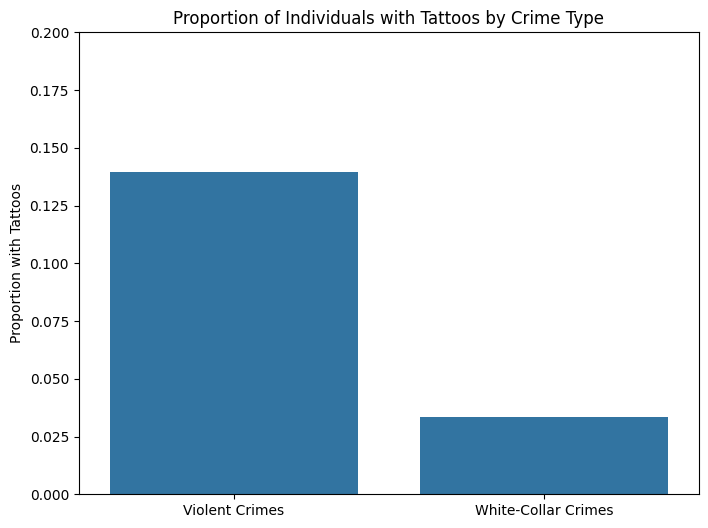

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. State the hypothesis
print("Hypothesis: Individuals wanted for violent crimes are more likely to have tattoos than individuals wanted for white-collar crimes.")

# 2. Report the calculated proportions
print(f"\nProportion of individuals with tattoos in Violent Crimes: {proportion_violent_crime_tattoo:.4f}")
print(f"Proportion of individuals with tattoos in White-Collar Crimes: {proportion_white_collar_crime_tattoo:.4f}")

# 3. Summarize the statistical test results (Chi-squared test)
print("\nStatistical Test Summary (Chi-squared test):")
print(f"Test performed: Chi-squared test of independence")
print(f"Calculated p-value: {p_value:.4f}")
print(f"Significance level (alpha): {alpha}")

if p_value < alpha:
    print("Result: We reject the null hypothesis.")
    print("Interpretation: There is a statistically significant difference in the proportion of individuals with tattoos between violent and white-collar crime entries.")
else:
    print("Result: We fail to reject the null hypothesis.")
    print("Interpretation: There is no statistically significant difference in the proportion of individuals with tattoos between violent and white-collar crime entries.")

# 4. Conclude by directly addressing the hypothesis
print("\nConclusion:")
if p_value < alpha:
    print("Based on the analysis, there is statistically significant evidence to support the hypothesis that individuals wanted for violent crimes are more likely to have tattoos than individuals wanted for white-collar crimes in this dataset.")
else:
    print("Based on the analysis, there is no statistically significant evidence to support the hypothesis that individuals wanted for violent crimes are more likely to have tattoos than individuals wanted for white-collar crimes in this dataset.")

# 5. Create a bar plot to visualize the proportions
crime_types = ['Violent Crimes', 'White-Collar Crimes']
proportions = [proportion_violent_crime_tattoo, proportion_white_collar_crime_tattoo]

plt.figure(figsize=(8, 6))
sns.barplot(x=crime_types, y=proportions)
plt.ylabel('Proportion with Tattoos')
plt.title('Proportion of Individuals with Tattoos by Crime Type')
plt.ylim(0, 0.2) # Set y-limit to better visualize the difference
plt.show()

## Summary:

### Data Analysis Key Findings

*   Approximately 13.93% of individuals categorized as violent crimes had tattoos.
*   Approximately 3.35% of individuals categorized as white-collar crimes had tattoos.
*   A Chi-squared test of independence resulted in a p-value of 0.0000.

### Insights or Next Steps

*   The statistically significant difference (p < 0.05) indicates that individuals wanted for violent crimes are more likely to have tattoos than those wanted for white-collar crimes in this dataset.
*   Further analysis could explore other demographic factors or crime subtypes within the violent and white-collar categories to identify more granular patterns related to the presence of tattoos.
